In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as ls 
from tqdm import tqdm
from scipy.signal import find_peaks


import matplotlib as mpl
mpl.rc('font', size=18)
mpl.rc('legend', fontsize=18)
mpl.rc('legend', numpoints=1)
mpl.rc('legend', handlelength=1.5)
mpl.rc('legend', frameon=False)
#mpl.rc('xtick.major', pad=7)
#mpl.rc('xtick.minor', pad=7)
mpl.rc('lines', lw=2)
mpl.rc('xtick',labelsize =15) 
mpl.rc('ytick',labelsize =15)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### The non-Hermitian Quantum walker

$$ H_{tot} = H_{search} + V, $$

where $V = -i\kappa |w \rangle \langle w |$ and $H_{search} = - \gamma N |s\rangle\langle s| - |w\rangle\langle w | $ with $\kappa > 0$.




Question: What is the effect of the non-hermitian part in the search process, and how one can optimize it for the best search process?

In [10]:
def H_total(N,gamma,w,kappa):
    
    #Hamiltonian matrix
    ket_s = (1.0/np.sqrt(N))*np.ones((N,1))
    H = -gamma*N*np.dot(ket_s,np.conjugate(ket_s).transpose())
        
    # Ensure H can handle complex numbers
    H = H.astype(complex)
    
    H[w,w] = H[w,w] - 1 - 1j*kappa
    
    return H        

In [3]:
def lambda_pm(N,gamma,kappa):

    lambda_plus  = -(gamma*N + 1 + 1.0j*kappa)/2  + np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))
    lambda_minus = -(gamma*N + 1 + 1.0j*kappa)/2  - np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))

    return lambda_plus,lambda_minus

In [4]:
#parameters
N = 500
gamma =  1
kappa = 0.1

lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

There are three eigenvalues approximately

1) $-\gamma N$
2) $-1 - i\kappa$
3) $0 \quad $ $N - 2 \,\,\text{degenerate}$

The exact values are

1) $-\frac{\gamma N + 1 + i \kappa}{2}  - \sqrt{\left( \frac{\gamma N + 1 + i \kappa}{2} \right)^2 - (\gamma N - \gamma)(1 + i \kappa)}$
2) $-\frac{\gamma N + 1 + i \kappa}{2}  + \sqrt{\left( \frac{\gamma N + 1 + i \kappa}{2} \right)^2 - (\gamma N - \gamma)(1 + i \kappa)}$
3) $0 \quad $ $N - 2 \,\,\text{degenerate}$

The imaginary part will be responsible for the decrease in population from the target site and increase in population of the detector state. We want to fix $\kappa$ and try to optimize $\gamma$ so that there is maximal decrease in population from the target site.

In [146]:
#parameters
N = 500
gamma =  1
w  = 10
kappa = 0.1

#Hamiltonian matrix
H = H_total(N,gamma,w,kappa)

#get the eigenvalue and right eigenstates
eigval,_ = np.linalg.eig(H)

#get the eigenvalue and left eigenstates
eigval_2,_ = np.linalg.eig(np.transpose(H))


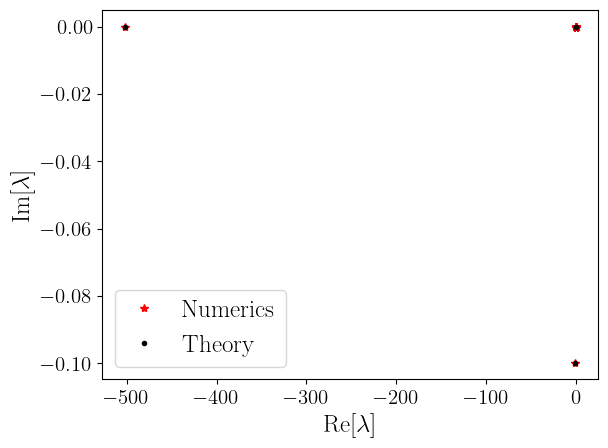

In [145]:
plt.plot(np.real(eigval),np.imag(eigval),'r*',label = 'Numerics')

plt.plot(0,0,'k.')
plt.plot(np.real(lambda_plus),np.imag(lambda_plus),'k.', label = 'Theory')
plt.plot(np.real(lambda_minus),np.imag(lambda_minus),'k.')

plt.legend(frameon = True)

plt.xlabel(r'Re$[\lambda]$')
plt.ylabel(r'Im$[\lambda]$')

plt.show()

Checking the overlap of the eigenvectors with the initial state corresponding too these different eigenvalues. Since we have a different left and right eigenvectors, we consider the quantity

$$\langle E_0^L | s \rangle \langle s | E_0^R \rangle \,\, \text{and}\,\, \langle E_1^L | s \rangle \langle s | E_1^R \rangle$$ 


In [139]:
def ket_lambda(N,gamma,kappa):

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- lambda_plus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
    N_plus = 1/np.sqrt(a_plus**2 + 1)

    ket_lambda_plus = N_plus*np.array([a_plus,b_plus])


    a_minus = (- lambda_minus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    N_minus = 1/np.sqrt(a_minus**2 + 1)

    ket_lambda_minus = N_minus*np.array([a_minus,b_minus])

    return ket_lambda_plus, ket_lambda_minus

In [148]:
ket_s = np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])

ket_w = np.array([1,0])

#overlap theoretically
#parameters
N = 500
w  = 10
kappa = 1
gamma = np.arange(0.0001,0.004,0.0001)

overlap_0 = np.zeros(len(gamma),dtype=np.complex_)
overlap_1 = np.zeros(len(gamma),dtype=np.complex_)
overlap_2 = np.zeros(len(gamma),dtype=np.complex_)
overlap_3 = np.zeros(len(gamma),dtype=np.complex_)

for i in tqdm(range(len(gamma))):
    ket_lambda_plus, ket_lambda_minus = ket_lambda(N,gamma[i],kappa)


    overlap_0[i] = np.abs(np.vdot(ket_lambda_plus,ket_s)*np.vdot(ket_s, ket_lambda_plus))
    overlap_1[i] = np.abs(np.vdot(ket_lambda_plus,ket_w)*np.vdot(ket_w, ket_lambda_plus))

    overlap_2[i] = np.abs(np.vdot(ket_lambda_minus,ket_s)*np.vdot(ket_s, ket_lambda_minus))
    overlap_3[i] = np.abs(np.vdot(ket_lambda_minus,ket_w)*np.vdot(ket_w, ket_lambda_minus))

100%|██████████| 39/39 [00:00<00:00, 31229.07it/s]


In [149]:
#parameters
N = 500
w  = 10
kappa = 1
gamma = np.arange(0.0001,0.004,0.0001)

overlap_right0 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left0 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right1 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left1 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right2 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left2 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right3 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left3 = np.zeros(len(gamma),dtype=np.complex_)

#calculate the overlap
psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for i in tqdm(range(len(gamma))):
    
    #Hamiltonian matrix
    H = H_total(N,gamma[i],w,kappa)
    
    #get the eigenvalue and right eigenstates
    eigval,eigvec_right = np.linalg.eig(H)

    #get the eigenvalue and left eigenstates
    eigval_2,eigvec_left = np.linalg.eig(np.transpose(H))

    overlap_right0[i] = np.vdot(psi_0,eigvec_right[:,0])
    overlap_left0[i] = np.vdot(eigvec_left[:,0],psi_0)

    overlap_right1[i] = np.vdot(psi_0,eigvec_right[:,1])
    overlap_left1[i] = np.vdot(eigvec_left[:,1],psi_0)



    overlap_right2[i] = np.vdot(ket_w,eigvec_right[:,0])
    overlap_left2[i] = np.vdot(eigvec_left[:,0],ket_w)

    overlap_right3[i] = np.vdot(ket_w,eigvec_right[:,1])
    overlap_left3[i] = np.vdot(eigvec_left[:,1],ket_w)  


100%|██████████| 39/39 [00:34<00:00,  1.14it/s]


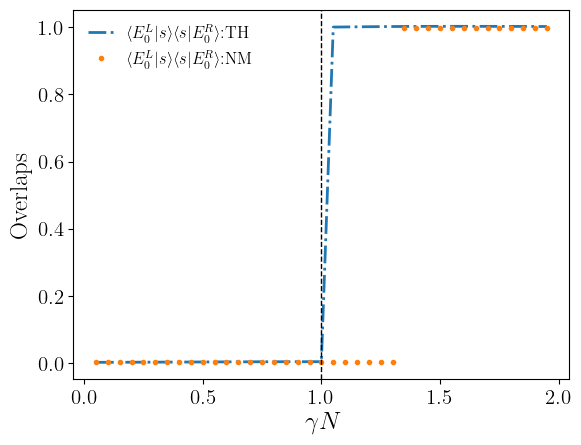

In [150]:
#plt.plot(gamma*N, np.abs(overlap_0),'.',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle $')

#plt.plot(gamma*N, np.abs(overlap_1),'^',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle$')

plt.plot(gamma*N, np.abs(overlap_2),'-.',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle $:TH')
plt.plot(gamma*N, np.abs(np.multiply(overlap_left0,overlap_right0)),'.',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle $:NM')

#plt.plot(gamma*N, np.abs(overlap_3),'--',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle$')

plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

plt.legend(fontsize = 12)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')
#plt.title(r'$\kappa = 1.5, N = 500$')

#plt.savefig(r'Overlap_k1_N500.pdf',bbox_inches = 'tight')
plt.show()


In [89]:
#parameters
N = 500
w  = 10
kappa = 0
gamma = np.arange(0.0001,0.004,0.0001)

overlap_right0 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left0 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right1 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left1 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right2 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left2 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right3 = np.zeros(len(gamma),dtype=np.complex_)
overlap_left3 = np.zeros(len(gamma),dtype=np.complex_)

#calculate the overlap
psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for i in tqdm(range(len(gamma))):
    
    #Hamiltonian matrix
    H = H_total(N,gamma[i],w,kappa)
    
    #get the eigenvalue and right eigenstates
    eigval,eigvec_right = np.linalg.eig(H)

    #get the eigenvalue and left eigenstates
    eigval_2,eigvec_left = np.linalg.eig(np.transpose(H))

    overlap_right0[i] = np.vdot(psi_0,eigvec_right[:,0])
    overlap_left0[i] = np.vdot(eigvec_left[:,0],psi_0)

    overlap_right1[i] = np.vdot(psi_0,eigvec_right[:,1])
    overlap_left1[i] = np.vdot(eigvec_left[:,1],psi_0)



    overlap_right2[i] = np.vdot(ket_w,eigvec_right[:,0])
    overlap_left2[i] = np.vdot(eigvec_left[:,0],ket_w)

    overlap_right3[i] = np.vdot(ket_w,eigvec_right[:,1])
    overlap_left3[i] = np.vdot(eigvec_left[:,1],ket_w)  


100%|██████████| 39/39 [00:27<00:00,  1.41it/s]


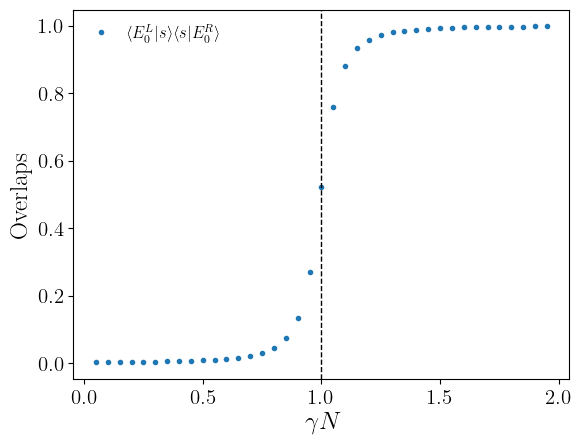

In [143]:
plt.plot(gamma*N, np.abs(np.multiply(overlap_left0,overlap_right0)),'.',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle $')

#plt.plot(gamma*N, np.abs(np.multiply(overlap_left1,overlap_right1)),'^',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle$')

#plt.plot(gamma*N, np.abs(np.multiply(overlap_left2,overlap_right2)),'-.',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle $')

#plt.plot(gamma*N, np.abs(np.multiply(overlap_left3,overlap_right3)),'--',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle$')

plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

plt.legend(fontsize = 12)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')
#plt.title(r'$\kappa = 1.5, N = 500$')

#plt.savefig(r'Overlap_k1_N500.pdf',bbox_inches = 'tight')
plt.show()


Let's calculate the survival probability $S(t)$.

In [77]:
N = 500
w  = 10
kappa = [0.001,0.01,0.1,1,10]
gamma = np.arange(0.0001,0.01,0.0001)

T = 400
dt = 0.01
m  = int(T/dt)

s_prob4_ = np.zeros((len(gamma),m))

for k in tqdm(range(len(gamma))):
    
    H =  H_total(N,gamma[k],w,kappa[4])

    #initial state
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

    s_prob4_[k,0] = np.abs(np.vdot(psi_0,psi_0))

    #Time Evolution operator
    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

    for j in range(1,m):   plt.plot(gamma*N, np.abs(np.multiply(overlap_left0,overlap_right0)),'.',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle $')

#plt.plot(gamma*N, np.abs(np.multiply(overlap_left1,overlap_right1)),'^',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle$')

#plt.plot(gamma*N, np.abs(np.multiply(overlap_left2,overlap_right2)),'-.',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle $')

#plt.plot(gamma*N, np.abs(np.multiply(overlap_left3,overlap_right3)),'--',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle$')

plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

plt.legend(fontsize = 12)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')
plt.title(r'$\kappa = 1.5, N = 500$')

#plt.savefig(r'Overlap_k1_N500.pdf',bbox_inches = 'tight')
plt.show()
     

        #wavefunction after time evolution of dt
        psit = ut.dot(psi_0)    

        s_prob4_[k,j] = np.abs(np.vdot(psit,psit))

        psi_0 = psit  

100%|██████████| 99/99 [01:20<00:00,  1.24it/s]


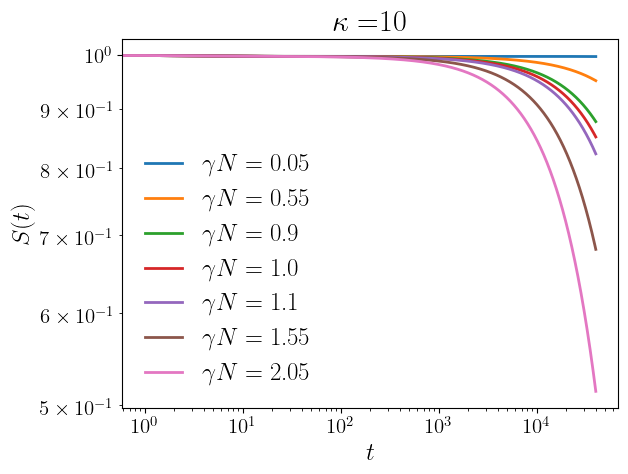

In [78]:
plt.plot(np.arange(m),s_prob4_[0],label =f'$\\gamma N =$ {gamma[0]*N}')
plt.plot(np.arange(m),s_prob4_[10],label =f'$\\gamma N =$ {gamma[10]*N}')
plt.plot(np.arange(m),s_prob4_[17],label =f'$\\gamma N =$ {np.round(gamma[17]*N,3)}')
plt.plot(np.arange(m),s_prob4_[19],label =f'$\\gamma N =$ {gamma[19]*N}')
plt.plot(np.arange(m),s_prob4_[21],label =f'$\\gamma N =$ {gamma[21]*N}')
plt.plot(np.arange(m),s_prob4_[30],label =f'$\\gamma N =$ {gamma[30]*N}')
plt.plot(np.arange(m),s_prob4_[40],label =f'$\\gamma N =$ {np.round(gamma[40]*N, 3)}')

plt.title(f'$\\kappa = ${kappa[4]}')
plt.loglog()

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t)$')
#plt.savefig('st_kappa10.pdf',bbox_inches = 'tight')
plt.show()

In [79]:
P_T4_ = np.zeros(len(gamma))
for i in range(len(gamma)):
    P_T4_[i] = 1 - s_prob4_[i][-1]

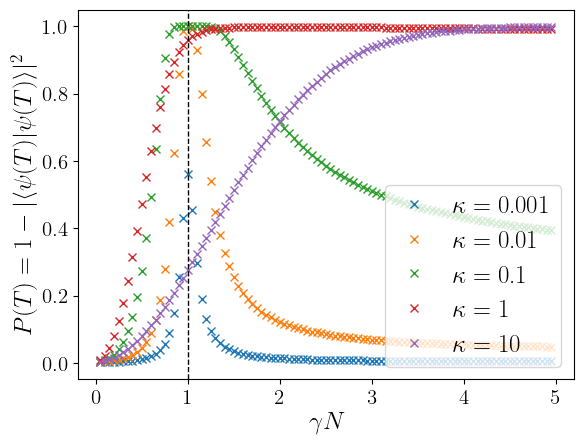

In [83]:
plt.plot(gamma*N, P_T0,'x',label = f'$\kappa=$ {kappa[0]}')
plt.plot(gamma*N, P_T1,'x',label = f'$\kappa=$ {kappa[1]}')
plt.plot(gamma*N, P_T2,'x',label = f'$\kappa=$ {kappa[2]}')
plt.plot(gamma*N, P_T3,'x',label = f'$\kappa=$ {kappa[3]}')
plt.plot(gamma*N, P_T4,'x',label = f'$\kappa=$ {kappa[4]}')


plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

plt.legend(loc = 'lower right', frameon = True)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$P(T) =  1 - |\langle \psi(T)|\psi(T) \rangle|^2$')
plt.savefig('det_prob_diff_kappa.pdf',bbox_inches = 'tight')
plt.show()

Check the other limit of hypercube. The adjacency matrix have the form
$$A = \sum_{j=1}^{N} \sigma_x^{(j)}$$

In [93]:
from functools import reduce

def pauli_x():
    #Pauli-X matrix
    return np.array([[0, 1],
                     [1, 0]])

def identity():
    #2x2 Identity matrix
    return np.eye(2)

def kronecker_sum_x(n):
    """
    Construct the adjacency matrix of an n-dimensional hypercube
    using Pauli-X matrices.
    """
    size = 2**n  # Total number of vertices
    adjacency_matrix = np.zeros((size, size))

    # Generate the adjacency matrix using the Kronecker sum
    for i in range(n):
        op = [identity()] * n
        #replace the ith element by the pauli x operator
        op[i] = pauli_x()

        #The reduce function applies the np.kron cumulatively to the elements in op
        adjacency_matrix += reduce(np.kron, op)

    return adjacency_matrix



In [94]:
# Check: 3-dimensional hypercube
n =3
adj_matrix = kronecker_sum_x(n)
print(adj_matrix.astype(int))  # Convert to int for better readability

[[0 1 1 0 1 0 0 0]
 [1 0 0 1 0 1 0 0]
 [1 0 0 1 0 0 1 0]
 [0 1 1 0 0 0 0 1]
 [1 0 0 0 0 1 1 0]
 [0 1 0 0 1 0 0 1]
 [0 0 1 0 1 0 0 1]
 [0 0 0 1 0 1 1 0]]


In [159]:

def hypercube_hamiltonian(dim,gamma, w, kappa):
    adj_matrix = kronecker_sum_x(dim)
    deg_matrix = dim*np.identity(2**dim)

    laplacian = deg_matrix - adj_matrix

    H = 0.5*gamma*laplacian

    # Ensure H can handle complex numbers
    H = H.astype(complex)
    
    #The search Hamiltonian with dissipation
    H[w,w] = H[w,w] - 1 - 1j*kappa

    return H

In [166]:
#parameters
dim = 10
gamma =  np.arange(0,0.6,0.01)
w  = 0
kappa = 0

eigval = np.zeros((len(gamma), 2**dim))

for i in range(len(gamma)):

    #Hamiltonian matrix
    H = hypercube_hamiltonian(dim,gamma[i],w,kappa)

    #get the eigenvalue and right eigenstates
    eigval[i],_ = np.linalg.eigh(H)

    #get the eigenvalue and left eigenstates
    #eigval_2,_ = np.linalg.eig(np.transpose(H))


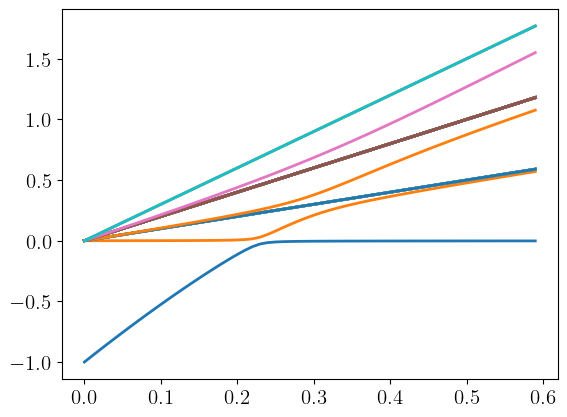

In [167]:
for i in range(len(gamma)):
    plt.plot(gamma,eigval[:,i])

/usr/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


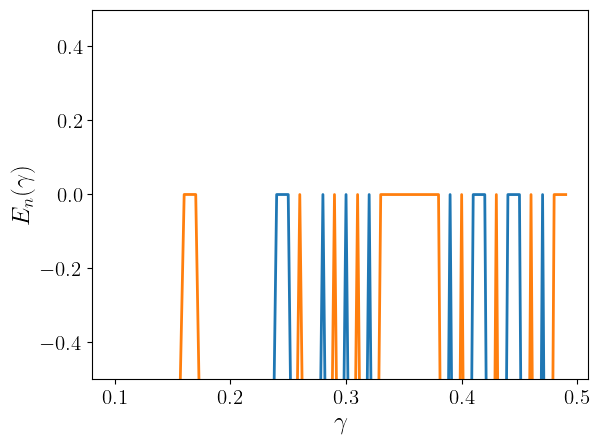

In [137]:
plt.plot(gamma,,'-',label = r'$E_0$')
plt.plot(gamma,E1,'-',label = r'$E_1$')

plt.ylabel(r'$E_n(\gamma)$')
plt.xlabel(r'$\gamma$')
plt.ylim(-0.5,0.5)
plt.show()

In [116]:
#parameters
dim =10
w  = 0
kappa = 0
gamma = np.arange(0.0001,0.0006,0.00005)

overlap_right0 = np.zeros(len(gamma),dtype=np.complex_)
#overlap_left0 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right1 = np.zeros(len(gamma),dtype=np.complex_)
#overlap_left1 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right2 = np.zeros(len(gamma),dtype=np.complex_)
#overlap_left2 = np.zeros(len(gamma),dtype=np.complex_)

overlap_right3 = np.zeros(len(gamma),dtype=np.complex_)
#overlap_left3 = np.zeros(len(gamma),dtype=np.complex_)

#calculate the overlap
psi_0 = (1.0/np.sqrt(2**dim))*np.ones((2**dim,1))

#target state
ket_w = np.zeros((2**dim,1))
ket_w[w] = 1

for i in tqdm(range(len(gamma))):
    
    #Hamiltonian matrix
    H = hypercube_hamiltonian(dim,gamma[i], w, kappa)
    
    #get the eigenvalue and right eigenstates
    eigval,eigvec = np.linalg.eig(H)

    overlap_right0[i] = np.abs(np.vdot(psi_0,eigvec_right[:,0]))**2
    #overlap_left0[i] = np.vdot(eigvec_left[:,0],psi_0)

    overlap_right1[i] = np.abs(np.vdot(psi_0,eigvec_right[:,1]))**2
    #overlap_left1[i] = np.vdot(eigvec_left[:,1],psi_0)



    overlap_right2[i] = np.abs(np.vdot(ket_w,eigvec_right[:,0]))**2
    #overlap_left2[i] = np.vdot(eigvec_left[:,0],ket_w)

    overlap_right3[i] = np.abs(np.vdot(ket_w,eigvec_right[:,1]))**2
    #overlap_left3[i] = np.vdot(eigvec_left[:,1],ket_w)  


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


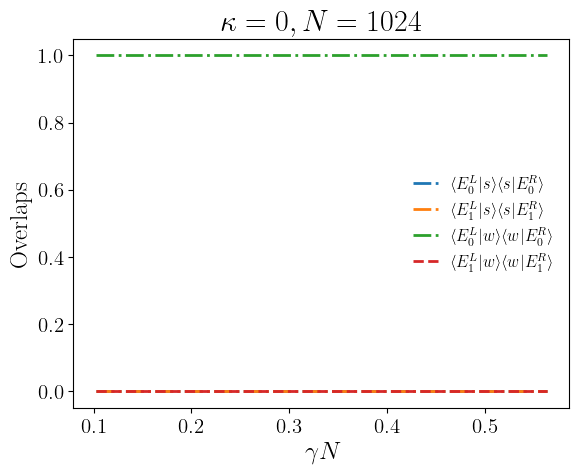

In [117]:
plt.plot(gamma*(2**dim), overlap_right0,'-.',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle $')

plt.plot(gamma*(2**dim), overlap_right1,'-.',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle$')

plt.plot(gamma*(2**dim), overlap_right2,'-.',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle $')

plt.plot(gamma*(2**dim), overlap_right3,'--',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle$')

#plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

plt.legend(fontsize = 12)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')
plt.title(r'$\kappa = 0, N = 1024$')

#plt.savefig(r'Overlap_k1_N500.pdf',bbox_inches = 'tight')
plt.show()


There seems a dependence on $\kappa$ on the transition point. Check analytically the overlaps and see whether we can find the transition . 

In the next part, we will compute the quantity fidelity for non-Hermitian Hamiltonian $$S(t) |\langle w|\psi(t)\rangle|^2,$$   with $S(t) =\langle \psi(t)|\psi(t)\rangle $,and compute the time taken to reach the first maximum ($T_{\rm opt}$)  and also the fidelity at the first maximum ($P_{\rm max}$) and see how it varies with $\gamma$ and $\kappa$.

In [226]:
N = 500
w  = 10
kappa = 1.5
gamma = np.arange(0.0001,0.01,0.0001)

T = 400
dt = 0.01
m  = int(T/dt)


P_max = np.zeros(len(gamma))
T_opt = np.zeros(len(gamma))

for k in tqdm(range(len(gamma))):
    
    w_prob = np.zeros(m)

    H =  H_total(N,gamma[k],w,kappa)

    #initial state
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

    #target state
    ket_w = np.zeros((N,1))
    ket_w[w] = 1

    w_prob[0] = np.abs(np.vdot(psi_0,psi_0))*np.abs(np.vdot(ket_w,psi_0))**2  

    #Time Evolution operator
    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

    for j in range(1,m):        

        #wavefunction after time evolution of dt
        psit = ut.dot(psi_0)    

        # Normalized fidelity
        w_prob[j] = np.abs(np.vdot(psit,psit))*np.abs(np.vdot(ket_w,psit))**2 

        psi_0 = psit  

    # Find peaks (local maxima)
    #peaks, _ = find_peaks(w_prob)

    # Get the first peak (first maxima)
    #first_maxima = peaks[0] if len(peaks) > 0 else None

    # Output the x and y values of the first maxima
    P_max[k] = np.max(w_prob)
    T_opt[k] = np.arange(m)[np.argmax(w_prob)]*dt


100%|██████████| 99/99 [01:31<00:00,  1.08it/s]


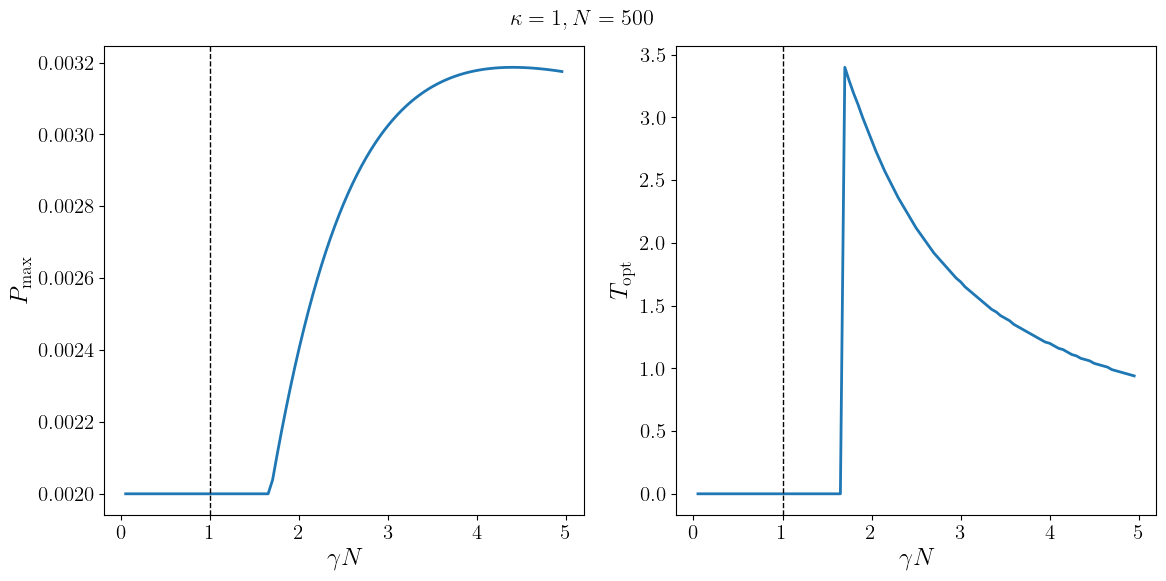

In [227]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First plot (P_max vs gamma)
ax[0].plot(gamma*N, P_max)
#ax[0].set_ylim(-0.1, 1.1)
ax[0].set_xlabel(r'$\gamma N$')
ax[0].set_ylabel(r'$P_{\rm{max}}$')
ax[0].axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

# Second plot (T_opt vs gamma)
ax[1].plot(gamma*N, T_opt)
ax[1].set_xlabel(r'$\gamma N$')
ax[1].set_ylabel(r'$T_{\rm{opt}}$')
ax[1].axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Title for the whole figure
fig.suptitle(r'$\kappa = 1, N = 500$', fontsize=16)
fig.subplots_adjust(top=0.92)


#save figure
#plt.savefig(r'Fidelity_k1.pdf',bbox_inches = 'tight')

# Show the plots
plt.show()

I saw for $\kappa =  1$,some strange behavior. I wanted to see what's happenning in the fidelity as a function of time for some specific values of $\gamma$.

In [242]:
N = 500
w  = 10
kappa = 1.5
gamma = [0.002,0.003,0.0035,0.01,0.1]

T = 400
dt = 0.01
m  = int(T/dt)

w_prob = np.zeros((len(gamma),m))



#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1


for k in tqdm(range(len(gamma))):
    
    #The Hamiltonian
    H =  H_total(N,gamma[k],w,kappa)

    #initial state
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

    #Initial overlap
    w_prob[k,0] = np.abs(np.vdot(psi_0,psi_0))*np.abs(np.vdot(ket_w,psi_0))**2  

    #Time Evolution operator
    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

    for j in range(1,m):        

        #wavefunction after time evolution of dt
        psit = ut.dot(psi_0)    

        # Normalized fidelity
        w_prob[k,j] = np.abs(np.vdot(psit,psit))*np.abs(np.vdot(ket_w,psit))**2 

        psi_0 = psit  


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


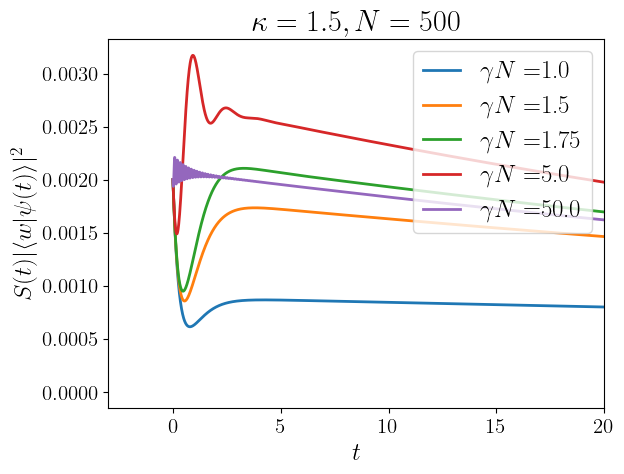

In [243]:
plt.plot(np.arange(m)*dt,w_prob[0],label = f'$\\gamma N=${gamma[0]*500}')
plt.plot(np.arange(m)*dt,w_prob[1],label = f'$\\gamma N=${gamma[1]*500}')
plt.plot(np.arange(m)*dt,w_prob[2],label = f'$\\gamma N=${gamma[2]*500}')
plt.plot(np.arange(m)*dt,w_prob[3],label = f'$\\gamma N=${gamma[3]*500}')
plt.plot(np.arange(m)*dt,w_prob[4],label = f'$\\gamma N=${gamma[4]*500}')
plt.title(r'$\kappa  = 1.5, N = 500$')

plt.xlim(-3,20)
plt.legend(frameon =True,loc = 'upper right')
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t) |\langle w|\psi(t)\rangle|^2$')

#plt.savefig('fidelity_time_kappa0p5-N500.pdf',bbox_inches = 'tight')
plt.show()

In [230]:
1.75/500

0.0035

I define the optimal $\gamma$ as the one for which the normalized fidelity attains the maximum value. I check how it varies with $N$ for different fixed $\kappa$.

In [213]:
N = np.arange(100,1100,100)
w  = 10
T = 400
dt = 0.1
m  = int(T/dt)
kappa = [0.001,0.01,0.1,0.5,1,2]
gamma = np.arange(0,0.1,0.001)


gamma_opt = np.zeros((len(kappa),len(N)))


for l in tqdm(range(len(kappa))):

    for k in range(len(N)):

        #compute the maximum normalized fidelity for different gamma
        w_prob_max =  np.zeros(len(gamma))

        for j in range(len(gamma)):

            w_prob = np.zeros(m)

            H =  H_total(N[k],gamma[j],w,kappa[l])

            #initial state
            psi_0 = (1.0/np.sqrt(N[k]))*np.ones((N[k],1))

            #target state
            ket_w = np.zeros((N[k],1))
            ket_w[w] = 1

            w_prob[0] = np.abs(np.vdot(psi_0,psi_0))*np.abs(np.vdot(ket_w,psi_0))**2  

            #Time Evolution operator
            ut = np.asarray(ls.expm(-(1.0j)*H*dt))

            for i in range(1,m):        

                #wavefunction after time evolution of dt
                psit = ut.dot(psi_0)    

                # Normalized fidelity
                w_prob[i] = np.abs(np.vdot(psit,psit))*np.abs(np.vdot(ket_w,psit))**2 

                psi_0 = psit 

            w_prob_max[j] = np.max(w_prob) 

        #optimal gamma for a fixed N and kappa
        gamma_opt[l,k] = gamma[np.argmax(w_prob_max)]


100%|██████████| 6/6 [34:02<00:00, 340.39s/it]


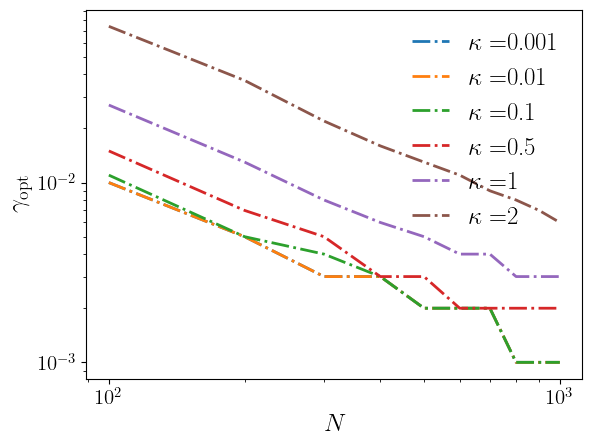

In [222]:
plt.plot(N, gamma_opt[0],'-.',label = f'$\\kappa = ${kappa[0]}')
plt.plot(N, gamma_opt[1],'-.',label = f'$\\kappa = ${kappa[1]}')
plt.plot(N, gamma_opt[2],'-.',label = f'$\\kappa = ${kappa[2]}')
plt.plot(N, gamma_opt[3],'-.',label = f'$\\kappa = ${kappa[3]}')
plt.plot(N, gamma_opt[4],'-.',label = f'$\\kappa = ${kappa[4]}')
plt.plot(N, gamma_opt[5],'-.',label = f'$\\kappa = ${kappa[5]}')

plt.legend()
plt.xlabel(r'$N$')
plt.ylabel(r'$\gamma_{\rm opt}$')
plt.loglog()
plt.show()

Using the optimum $\gamma$ value, we compute the complexity of the algorithm. 

In [220]:
N = np.arange(100,1100,100)
w  = 10
T = 400
dt = 0.1
m  = int(T/dt)
kappa = [0.001,0.01,0.1,0.5,1,2]


t_opt = np.zeros((len(kappa),len(N)))
prob_max = np.zeros((len(kappa),len(N)))


for k in tqdm(range(len(kappa))):

    for l in tqdm(range(len(N))):

        gamma = gamma_opt[k,l]


        w_prob = np.zeros(m)

        H =  H_total(N[l],gamma,w,kappa[k])

        #initial state
        psi_0 = (1.0/np.sqrt(N[l]))*np.ones((N[l],1))

        #target state
        ket_w = np.zeros((N[l],1))
        ket_w[w] = 1

        w_prob[0] = np.abs(np.vdot(psi_0,psi_0))*np.abs(np.vdot(ket_w,psi_0))**2


        #Time Evolution operator
        ut = np.asarray(ls.expm(-(1.0j)*H*dt))

        for j in range(1,m):        

            #wavefunction after time evolution of dt
            psit = ut.dot(psi_0)    

            # Normalized fidelity
            w_prob[j] = np.abs(np.vdot(psit,psit))*np.abs(np.vdot(ket_w,psit))**2 

            psi_0 = psit  


        t_opt[k,l]    = np.arange(m)[np.argmax(w_prob)]*dt
        prob_max[k,l] = np.max(w_prob)

100%|██████████| 6/6 [00:24<00:00,  4.01s/it]


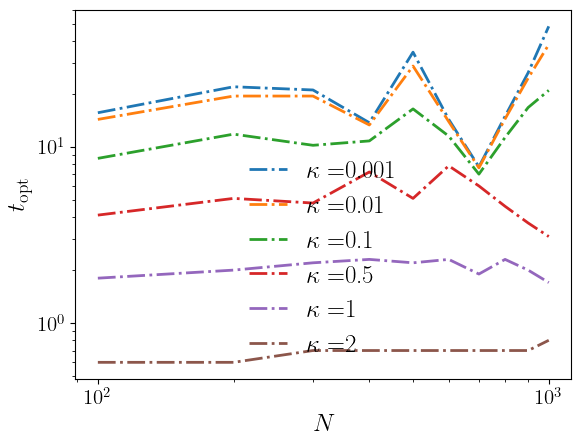

In [224]:
plt.plot(N, t_opt[0],'-.',label = f'$\\kappa = ${kappa[0]}')
plt.plot(N, t_opt[1],'-.',label = f'$\\kappa = ${kappa[1]}')
plt.plot(N, t_opt[2],'-.',label = f'$\\kappa = ${kappa[2]}')
plt.plot(N, t_opt[3],'-.',label = f'$\\kappa = ${kappa[3]}')
plt.plot(N, t_opt[4],'-.',label = f'$\\kappa = ${kappa[4]}')
plt.plot(N, t_opt[5],'-.',label = f'$\\kappa = ${kappa[5]}')

plt.legend()
plt.xlabel(r'$N$')
plt.ylabel(r'$t_{\rm opt}$')
plt.loglog()
plt.show()

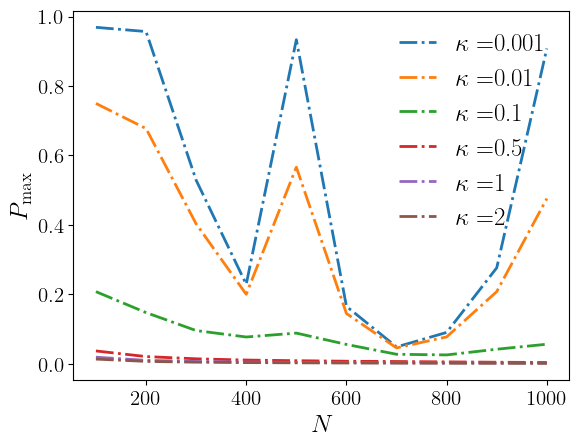

In [223]:
plt.plot(N, prob_max[0],'-.',label = f'$\\kappa = ${kappa[0]}')
plt.plot(N, prob_max[1],'-.',label = f'$\\kappa = ${kappa[1]}')
plt.plot(N, prob_max[2],'-.',label = f'$\\kappa = ${kappa[2]}')
plt.plot(N, prob_max[3],'-.',label = f'$\\kappa = ${kappa[3]}')
plt.plot(N, prob_max[4],'-.',label = f'$\\kappa = ${kappa[4]}')
plt.plot(N, prob_max[5],'-.',label = f'$\\kappa = ${kappa[5]}')

plt.legend()
plt.xlabel(r'$N$')
plt.ylabel(r'$P_{\rm max}$')
plt.show()